In [272]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from ipywidgets import Layout, Button, Box
from nested_dict import nested_dict
import ipywidgets as widgets
from collections import defaultdict
from pprint import pprint

import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns

sns.set(style="whitegrid")

In [273]:
artifacts_dir = "/Users/shubham/sandmark-nightly/sequential/"
pausetimes_dir = "/Users/shubham/sandmark-nightly/pausetimes/sequential"
default_hostname = None

In [274]:
bench_files = []

for root, dirs, files in os.walk(artifacts_dir):
    for file in files:
        if file.endswith("_1.orun.summary.bench"):
            f = root.split("/sequential/")
            bench_files.append((os.path.join(root, file)))

In [275]:
def files_to_dict(files):
    benches = nested_dict(2, list)
    for x in files:
        l = x.split("/sequential/")[1]
        d = l.split("/")
        host         = d[0]
        timestamp    = d[1]
        commit       = d[2]
        variant      = d[3]
        variant_root = d[3].split('_')[0]
        variant_stem = d[3].split('_')[1]
        value        = variant_root + '+' + commit + '_' + variant_stem
        benches[host][timestamp].append(value)
    benches = dict(benches)
    for i in benches.items():
        benches[i[0]] = dict(sorted(i[1].items(), key=lambda t : t[0], reverse=True))
    return benches

benches = files_to_dict(bench_files)

In [276]:
def f(x): return x

def disp(benches):
    def select_host(host):
        timestampW.options = benches[host]
    
    def select_commit(timestamp):
        variantW.options = timestamp
    
    def do_nothing(variant):
        return None

    hostW = widgets.Dropdown(options=benches.keys(), description='Host', disabled=False)
    hostS = hostW.value
    hostD = widgets.interactive(select_host, host=hostW)

    timestampW = widgets.Dropdown(options=benches[hostS].keys(), description='Timestamp', disabled=False, value=list(benches[hostS].keys())[0])
    timestampS = timestampW.value
    timestampD = widgets.interactive(select_commit, timestamp=timestampW)
    
    variantW = widgets.Dropdown(options=benches[hostS][timestampS], description='Variant', disabled=False)
    variantD = widgets.interactive(do_nothing, variant=variantW)

    items_layout = Layout( width='auto' )
    
    box_layout = Layout(display='flex',
                       flex_flow='row wrap',
                       align_items='flex-start',
                       width='100%')
    items = [hostD, timestampD, variantD]
    box = Box(children=items, layout=box_layout)
    
    display(box)
    
    return (hostD, timestampD, variantD)

def get_filename(h, t, v):
    # if-cond for generating html
    if default_hostname:
        host      = h.children[0].value

        timestamps = list(benches[host].keys())
        timestamp  = timestamps[t.children[0].index]
        variant = v.children[0].value
        commit = variant.split('_')[0].split('+')[-1]
        variant_stem = variant.split('_')[1]
        variant_value = '+'.join(variant.split('_')[0].split('+')[:-1]) + '_' + variant_stem
        
        filename = os.path.join(
            artifacts_dir,
            host,
            timestamp,
            commit,
            variant_value
        )
        return(filename)
    
    host      = h.children[0].value

    timestamps = list(benches[host].keys())
    timestamp  = timestamps[t.children[0].index]

    entries      = list(benches[host][timestamp])
    variant      = entries[v.children[0].index]
    commit       = variant.split('_')[0].split('+')[-1]
    variant_stem = variant.split('_')[1]
    variant_value = '+'.join(variant.split('_')[0].split('+')[:-1]) + '_' + variant_stem

    filename = os.path.join(
        artifacts_dir,
        host,
        timestamp,
        commit,
        variant_value
    )
    

    return filename

In [277]:

comparisons = interactive(f, x=widgets.IntText(value=2, 
                                               description='Comparisons', 
                                               disabled=False))
display(comparisons)

interactive(children=(IntText(value=2, description='Comparisons'), Output()), _dom_classes=('widget-interact',…

In [278]:
# if-cond for generating html
if default_hostname:
    timestamp = list(benches[default_hostname])[0]
    bench_files = [(timestamp, benches[default_hostname][timestamp])]
    bench1 = {
        default_hostname : {
            timestamp : [bench_files[0][1][0]]
        }
    }
    bench2 = {
        default_hostname : {
            timestamp : [bench_files[0][1][1]]
        }
    }

In [279]:
matrix = [[0 for x in range(4)] for y in range(comparisons.result)]
# if-cond for generating html
if default_hostname is None:
    for i in range(comparisons.result):
        matrix[i][0], matrix[i][1], matrix[i][2] = disp(benches)

else:
    matrix[0][0], matrix[0][1], matrix[0][2] = disp(bench1)
    matrix[1][0], matrix[1][1], matrix[1][2] = disp(bench2)

Box(children=(interactive(children=(Dropdown(description='Host', options=('navajo',), value='navajo'), Output(…

Box(children=(interactive(children=(Dropdown(description='Host', options=('navajo',), value='navajo'), Output(…

In [280]:
for i in range(comparisons.result):
    matrix[i][3] = get_filename(matrix[i][0], matrix[i][1], matrix[i][2])

In [281]:
selected_files = []
for i in range (comparisons.result):
    selected_files.append(matrix[i][3])

In [282]:
data_frames = []

for file in selected_files:
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        df = pdjson.json_normalize(data)
        value     = file.split('/sequential/')[1]
        date      = value.split('/')[1].split('_')[0]
        commit_id = value.split('/')[2][:7]
        variant   = value.split('/')[3].split('_')[0]
        df["variant"] = variant + '_' + date + '_' + commit_id
        data_frames.append(df)

df = pd.concat (data_frames, sort=False)
df = df.sort_values(['name'])
# Uncomment the following to display all the lines in pandas output
# pd.set_option('display.max_rows', df.shape[0]+1)

<ipython-input-282-2670cf8664c2>:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = pdjson.json_normalize(data)


In [283]:
df = df[(df.name != 'alt-ergo.fill.why') &         #multicore version does not exist
        (df.name != 'alt-ergo.yyll.why') &         #multicore version does not exist
        (df.name != 'frama-c.slevel') &            #multicore version does not exist
        (df.name != 'js_of_ocaml.frama-c_byte')]   #multicore version does not exist
throughput_df = df

In [284]:
# print(selected_files)
selected_benches = files_to_dict(selected_files)
# print(selected_benches['iitm'])
baseline_h, baseline_t, baseline_v = disp(selected_benches)

Box(children=(interactive(children=(Dropdown(description='Host', options=('navajo',), value='navajo'), Output(…

In [285]:
selected_baseline = ""
timestamp = list(baseline_t.children[0].options.keys())[0]
date      = timestamp.split('_')[0]
commit_id = baseline_v.children[0].value.split('_')[0].split('+')[-1][:7]
variant   = baseline_v.children[0].value.split('_')[0].split('+')
variant.pop()
variant   = "+".join(variant)
value     = variant + '_' + date + '_' + commit_id
selected_baseline = value

## Time

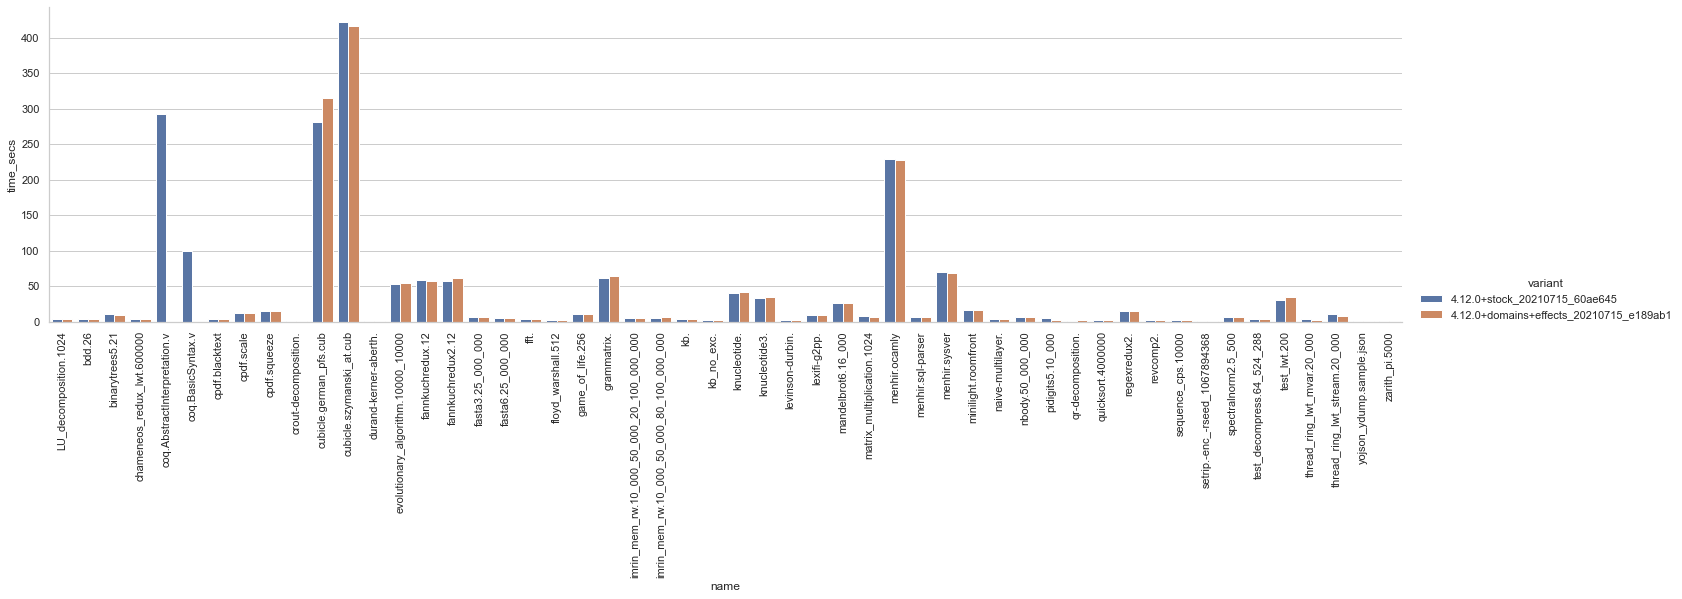

In [286]:
g = sns.catplot (x='name', y='time_secs', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalized

In [287]:
def create_column(df, variant, metric):
    df = pd.DataFrame.copy(df)
    variant_metric_name = list([ zip(df[metric], df[x], df['name'])
            for x in df.columns.array if x == "variant" ][0])
    name_metric = {n:t for (t, v, n) in variant_metric_name if v == variant}
    return name_metric

def add_display_name(df,variant, metric):
    name_metric = create_column(pd.DataFrame.copy(df), variant, metric)
    disp_name = [name+" ("+str(round(name_metric[name], 2))+")" for name in df["name"]]
    df["display_name"] = pd.Series(disp_name, index=df.index)
    return df

def normalise(df,variant,topic,additionalTopics=[]):
    df = add_display_name(df,variant,topic)
    df = df.sort_values(["name","variant"])
    grouped = df.filter(items=['name',topic,'variant','display_name']+additionalTopics).groupby('variant')
    ndata_frames = []
    for group in grouped:
        (v,data) = group
        if(v != variant):
            data['b'+topic] = grouped.get_group(variant)[topic].values
            data[['n'+topic]] = data[[topic]].div(grouped.get_group(variant)[topic].values, axis=0)
            for t in additionalTopics:
                data[[t]] = grouped.get_group(variant)[t].values
            ndata_frames.append(data)
            df = pd.concat(ndata_frames)
            return df
        else:
            print("The selected baseline variant is equal to the other variants\n" 
                  + "Update the dropdowns with different varians to plot normalisation graphs\n")
            return None

def plot_normalised(df,variant,topic):
    if df is not None:
        df = pd.DataFrame.copy(df)
        df.sort_values(by=[topic],inplace=True)
        df[topic] = df[topic] - 1
        g = sns.catplot (x="display_name", y=topic, hue='variant', data = df, kind ='bar', aspect=4, bottom=1)
        g.set_xticklabels(rotation=90)
        g.ax.legend(loc=8)
        g._legend.remove()
        g.ax.set_xlabel("Benchmarks")
        return g
        # g.ax.set_yscale('log')
    else:
        print("ndf is equal to None, possibly due to variants being equal to the baseline variant\n")

<ipython-input-287-fc65740bf716>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


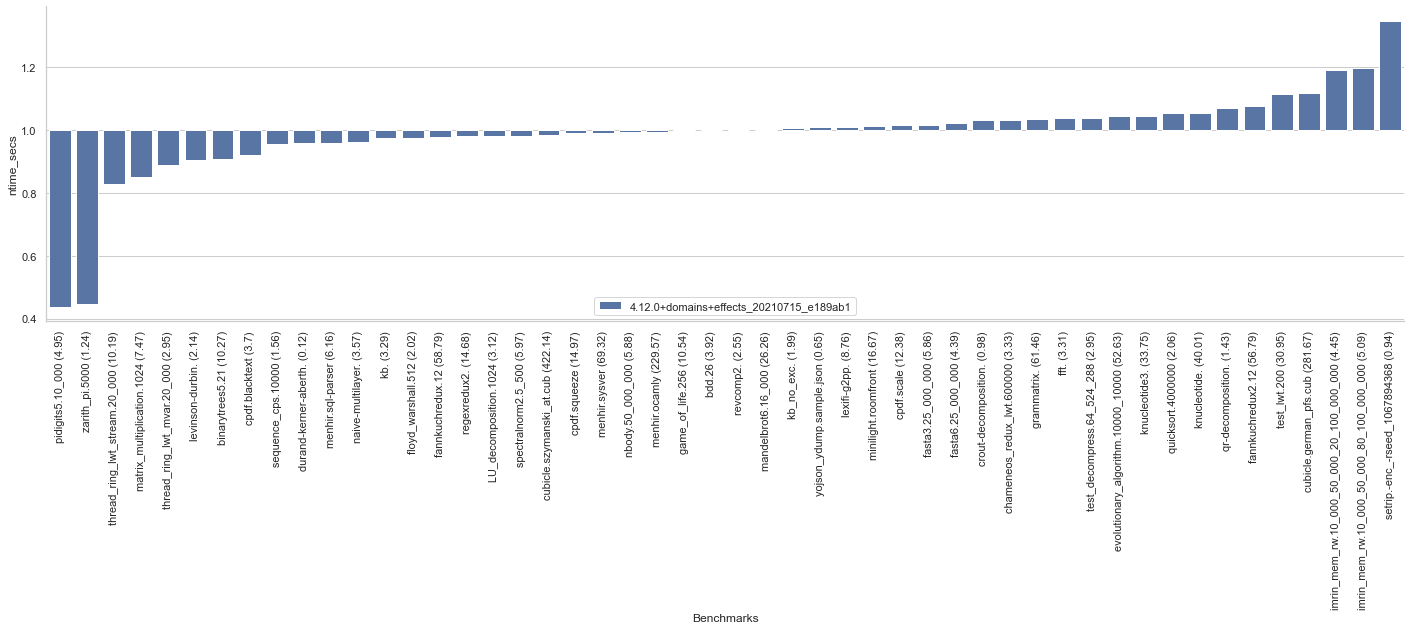

In [288]:
#FIXME : coq fails to build on navajo
df = df[(df.name != 'coq.BasicSyntax.v') & (df.name != 'coq.AbstractInterpretation.v')]

ndf = normalise(df, selected_baseline,'time_secs')
plot_normalised(ndf, selected_baseline,'ntime_secs')

## Top heap words

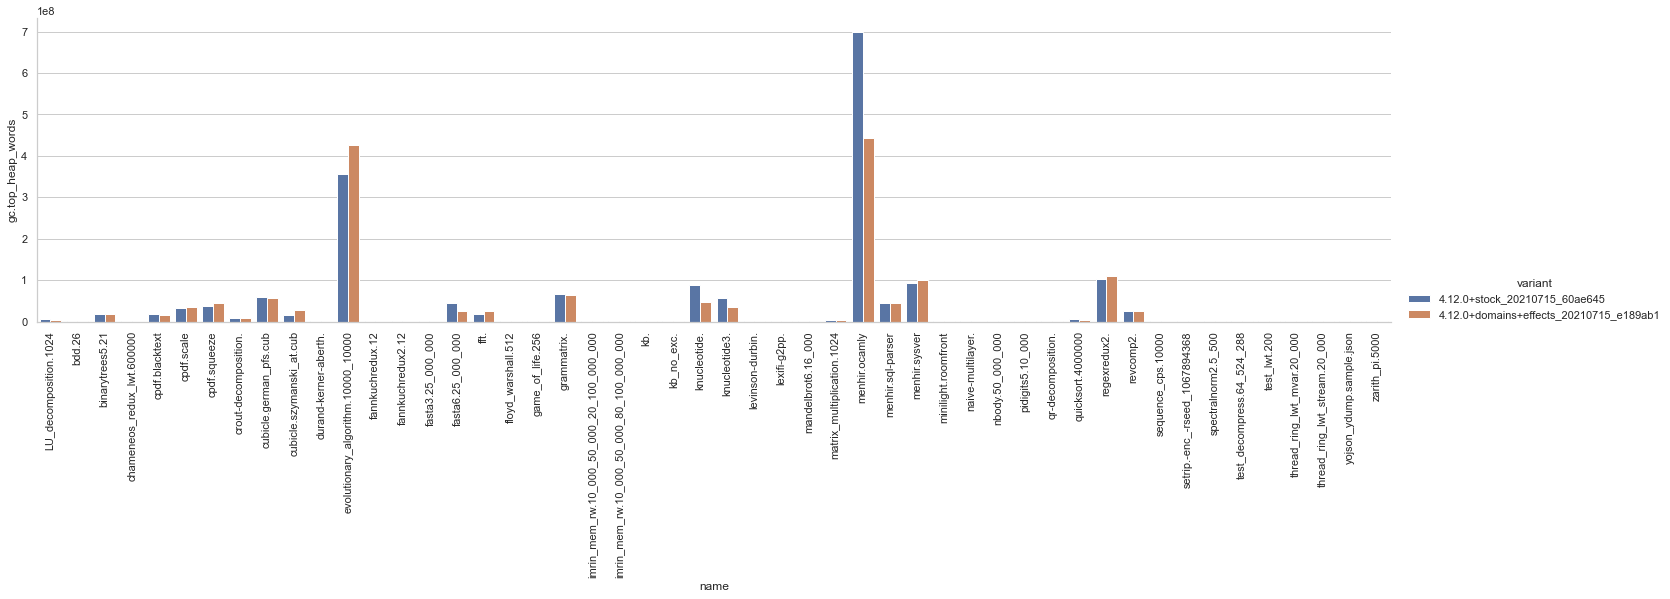

In [289]:
g = sns.catplot (x='name', y='gc.top_heap_words', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

<ipython-input-287-fc65740bf716>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


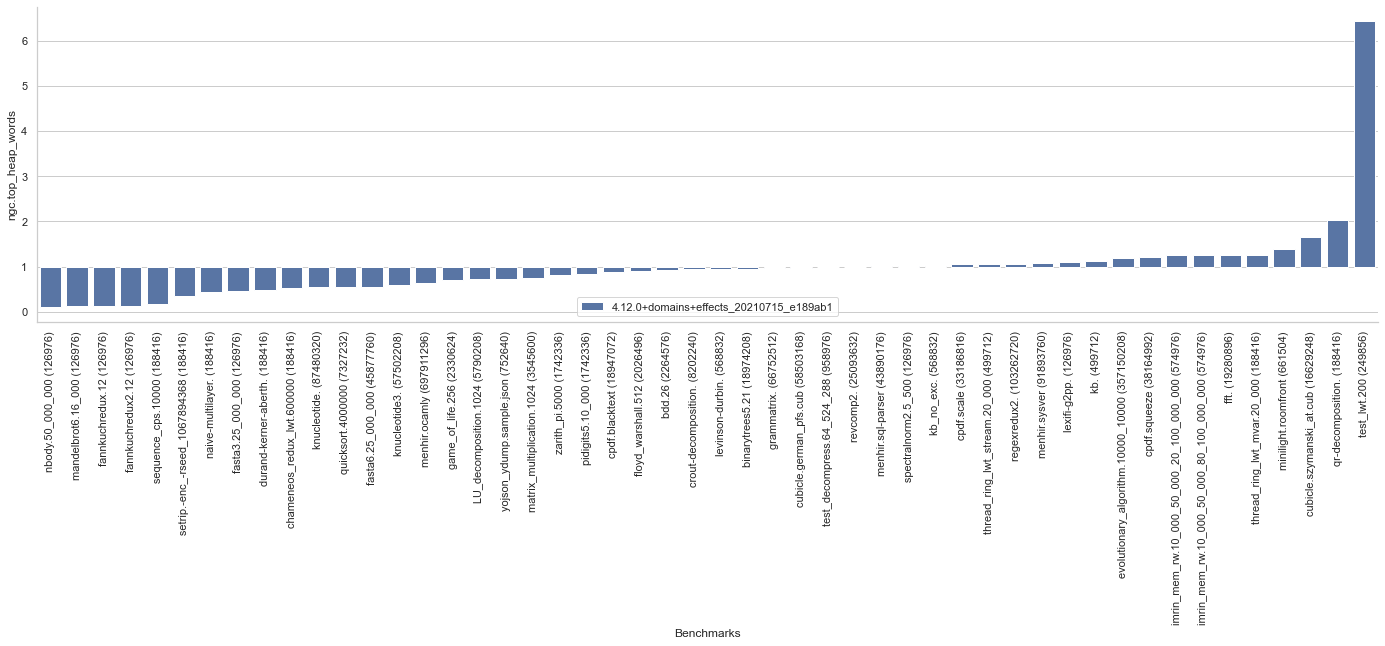

In [290]:
ndf = normalise(df,selected_baseline,'gc.top_heap_words')
plot_normalised(ndf,selected_baseline,'ngc.top_heap_words')

## Max RSS (KB)

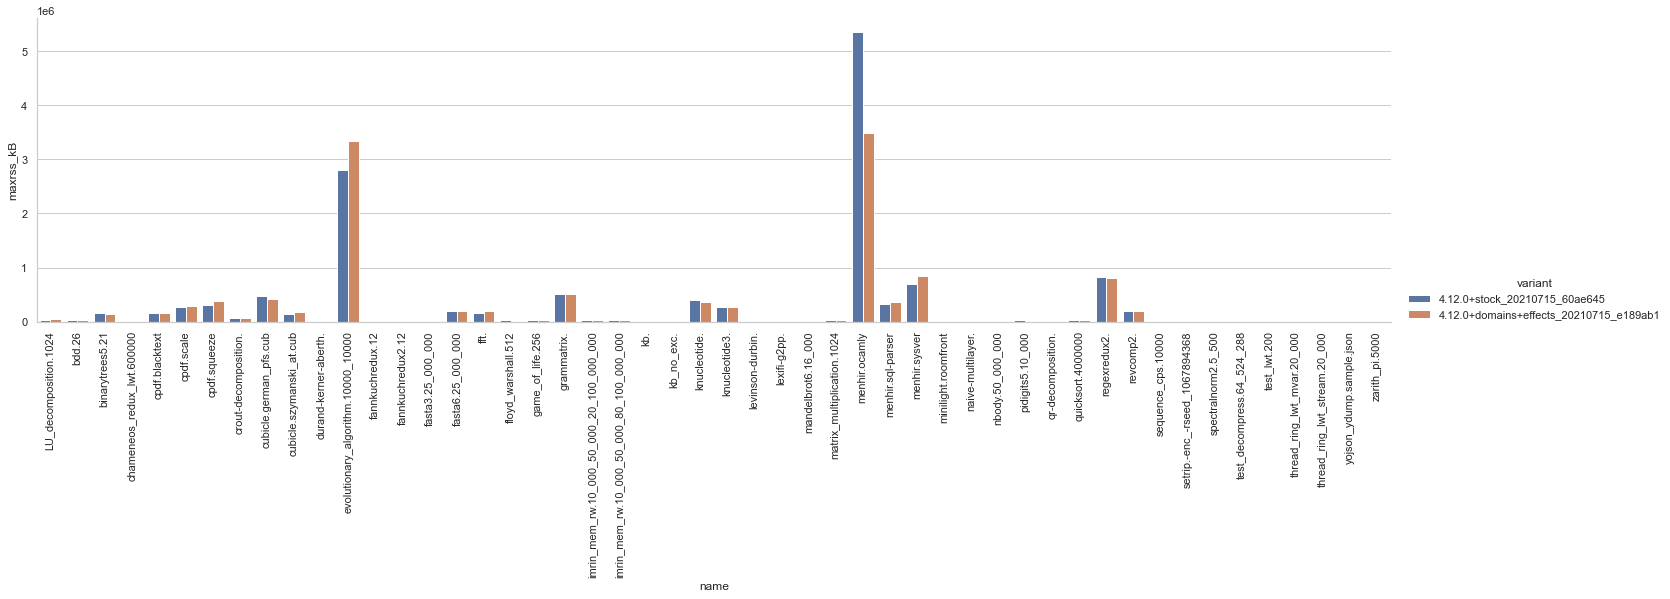

In [291]:
g = sns.catplot (x='name', y='maxrss_kB', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

<ipython-input-287-fc65740bf716>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


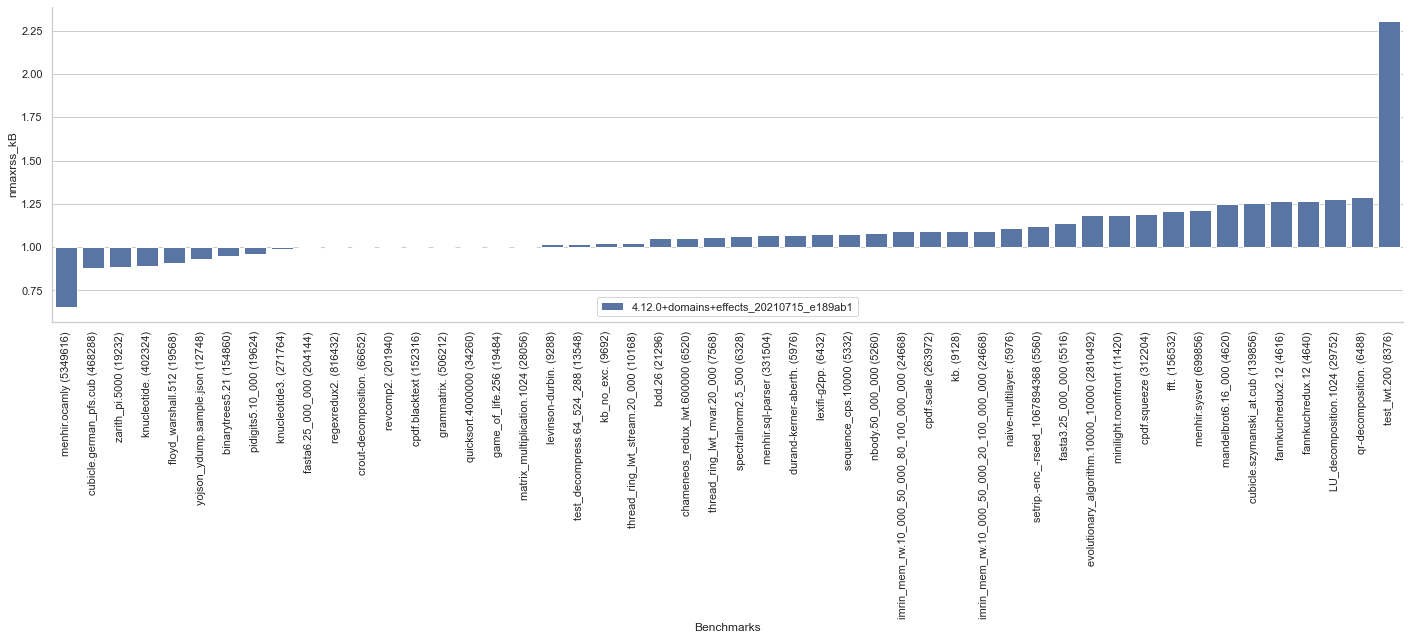

In [292]:
ndf = normalise(df,selected_baseline,'maxrss_kB')
plot_normalised(ndf,selected_baseline,'nmaxrss_kB')

## Major Collections

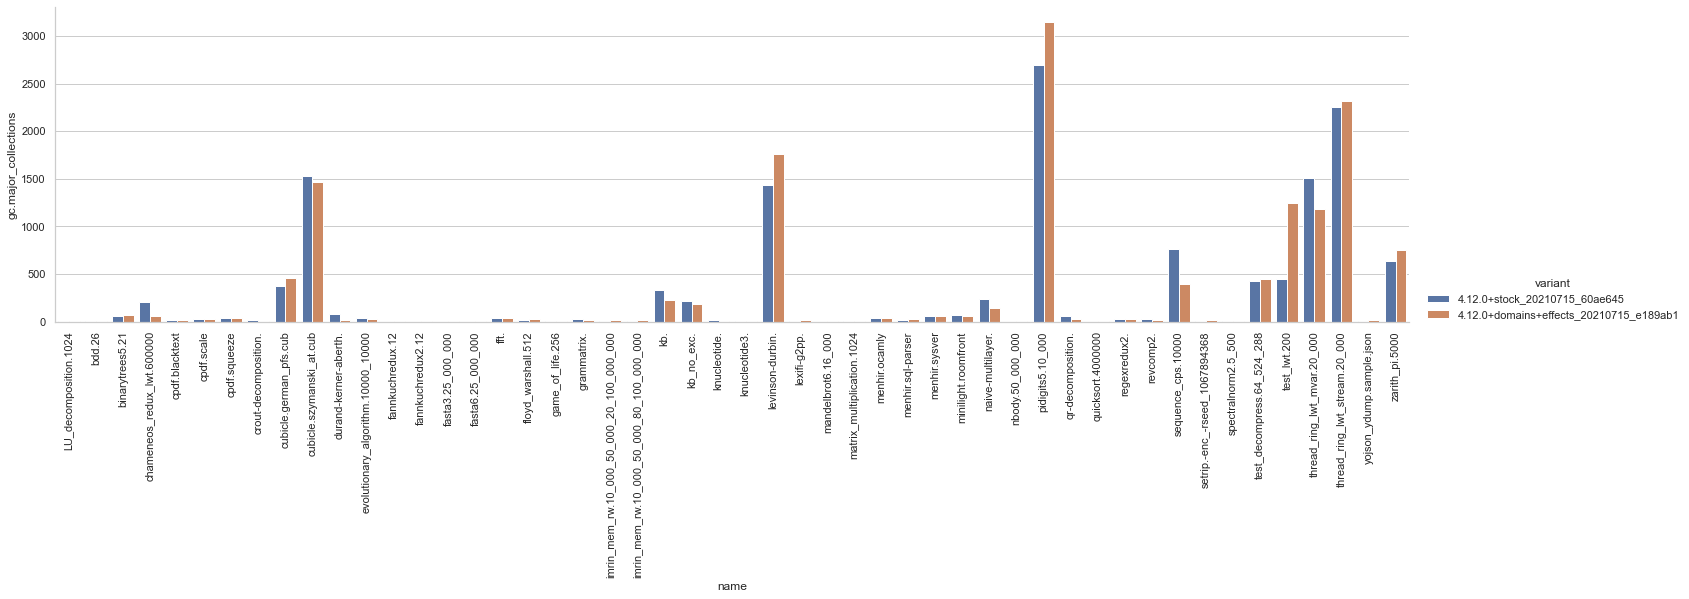

In [293]:
g = sns.catplot (x='name', y='gc.major_collections', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

<ipython-input-287-fc65740bf716>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


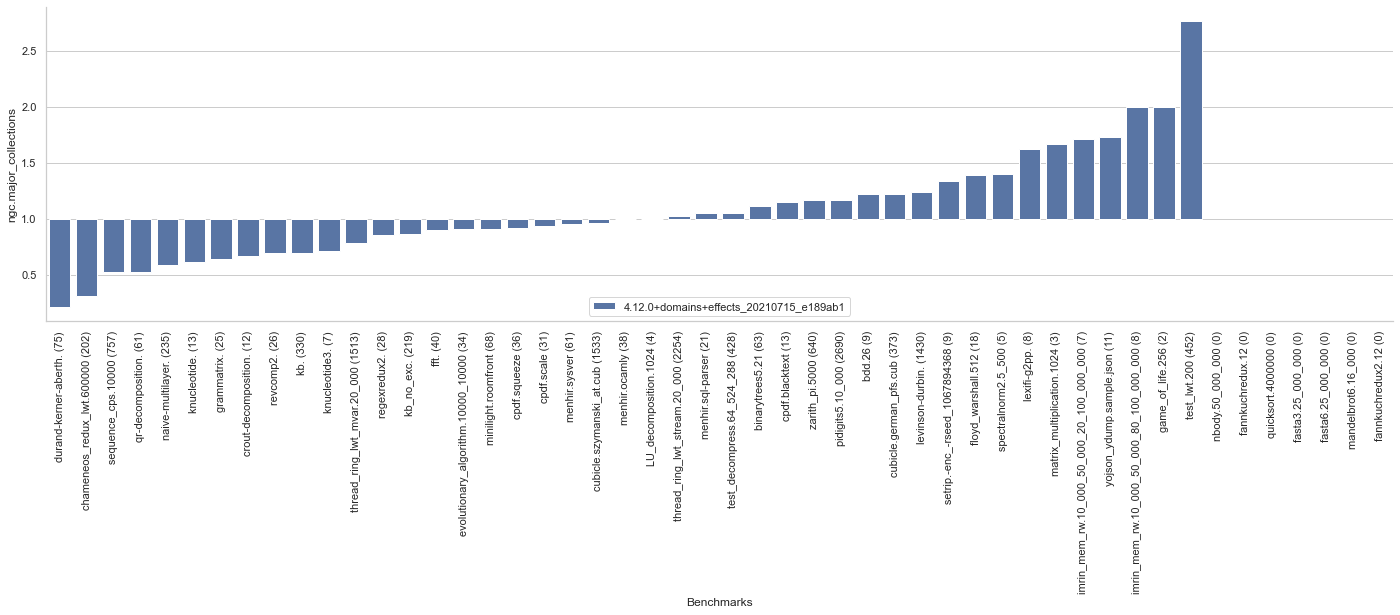

In [294]:
ndf = normalise(df,selected_baseline,'gc.major_collections')
plot_normalised(ndf,selected_baseline,'ngc.major_collections')

## Major words

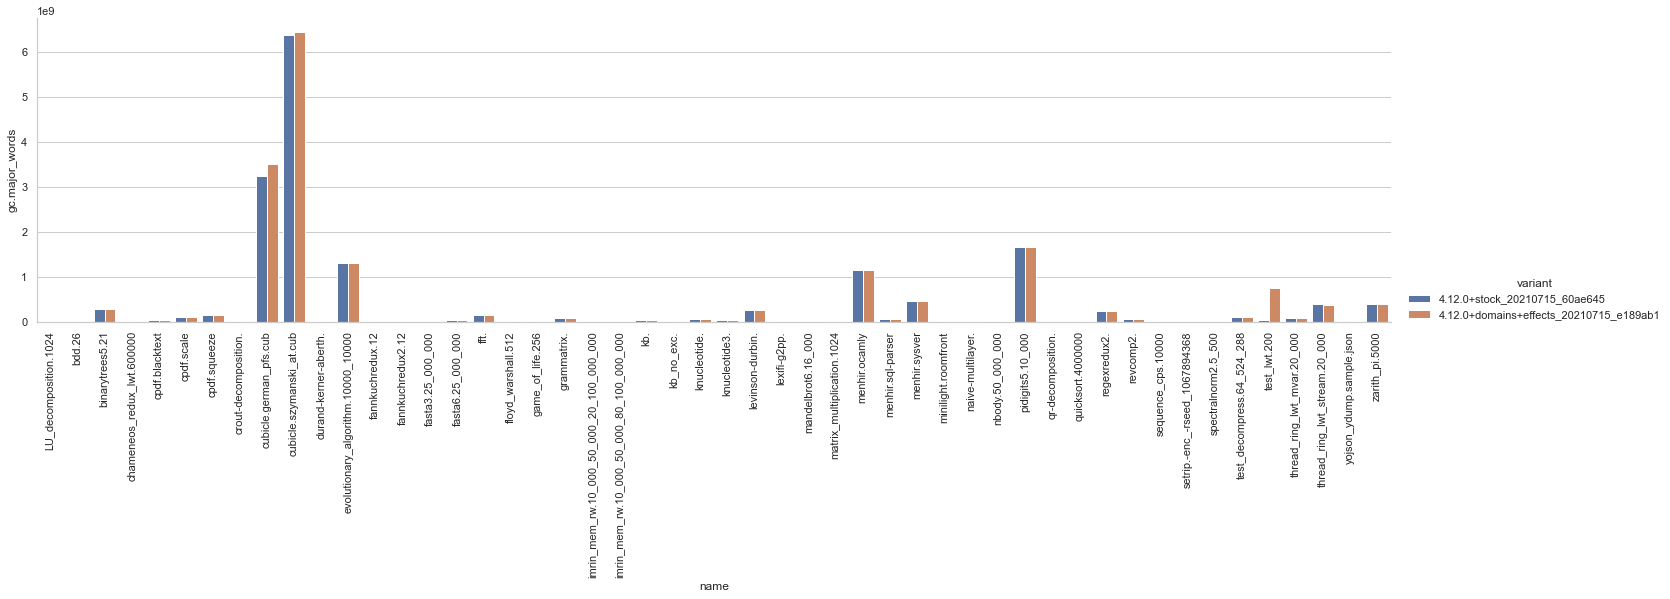

In [295]:
g = sns.catplot (x='name', y='gc.major_words', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

<ipython-input-287-fc65740bf716>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


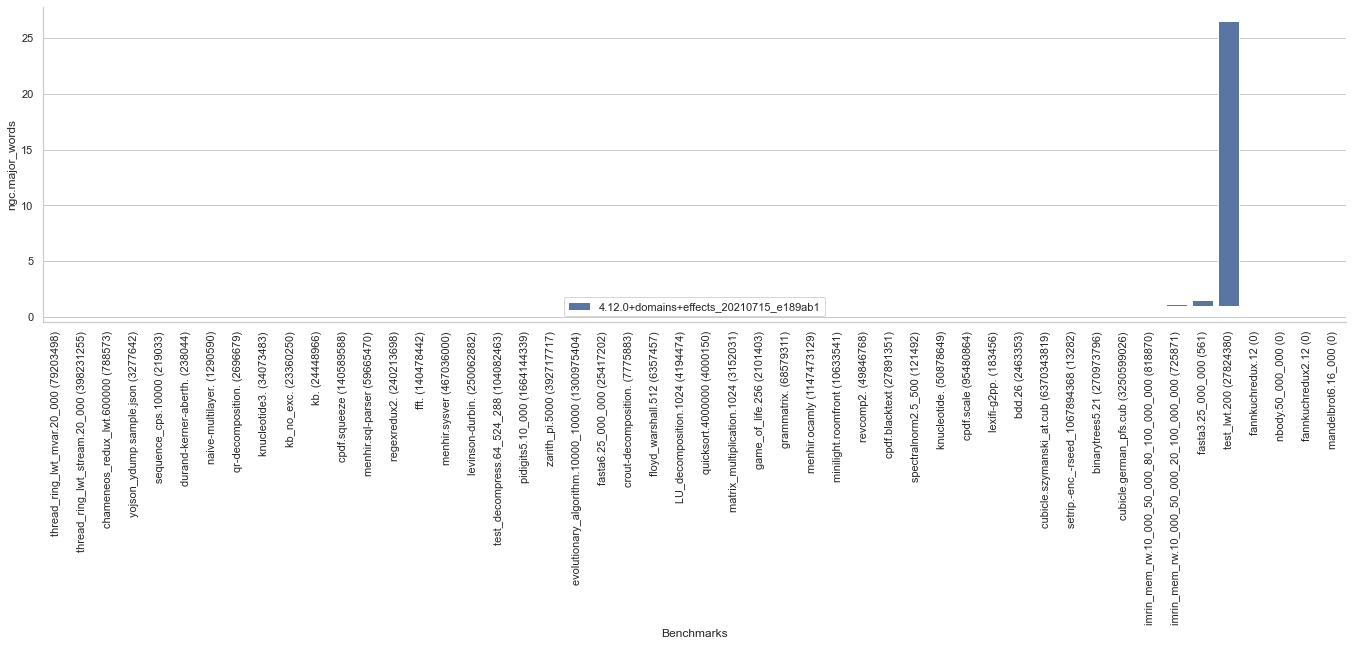

In [296]:
ndf = normalise(df,selected_baseline,'gc.major_words')
plot_normalised(ndf,selected_baseline,'ngc.major_words')

## Minor Collections

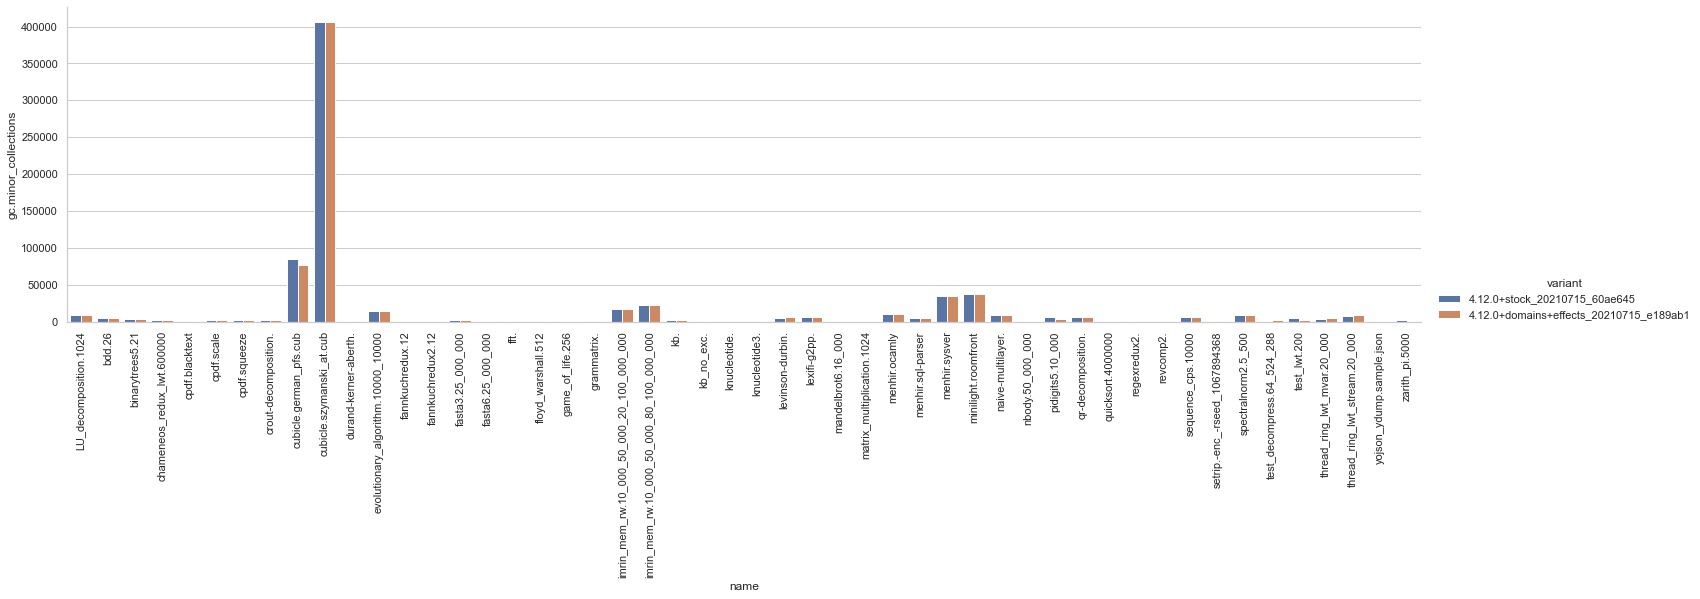

In [297]:
g = sns.catplot (x='name', y='gc.minor_collections', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

<ipython-input-287-fc65740bf716>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


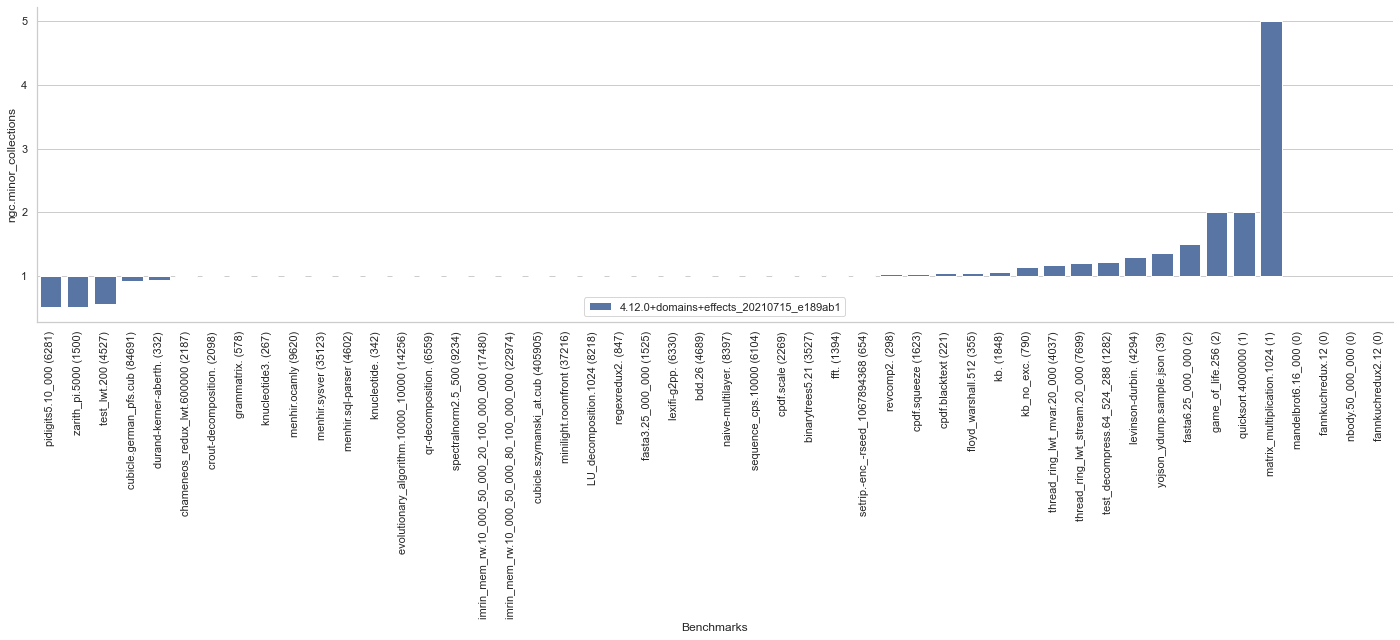

In [298]:
ndf = normalise(df,selected_baseline,'gc.minor_collections')
plot_normalised(ndf,selected_baseline,'ngc.minor_collections')

# Instrumented Pausetimes

In [299]:
def files_to_dict_pausetimes(files):
    benches = nested_dict(2, list)
    for x in files:
        l = x.split("/sequential/")[1]
        d = l.split("/")
        host         = d[0]
        timestamp    = d[1]
        commit       = d[2]
        variant      = d[3]
        variant_root = d[3].split('_')[0]
        variant_stem = d[3].split('_')[1] + '_' + d[3].split('_')[2]
        value        = variant_root + '+' + commit + '_' + variant_stem
        benches[host][timestamp].append(value)
    benches = dict(benches)
    for i in benches.items():
        benches[i[0]] = dict(sorted(i[1].items(), key=lambda t : t[0], reverse=True))
    return benches

In [300]:
pausetimes_files = []

for root, dirs, files in os.walk(pausetimes_dir):
    for file in files:
        if file.endswith("_1.pausetimes_trunk.summary.bench") or file.endswith("_1.pausetimes_multicore.summary.bench"):
            f = root.split("/sequential/")
            pausetimes_files.append((os.path.join(root, file)))

pausetimes = files_to_dict_pausetimes(pausetimes_files)

def f(x):
    return x

if default_hostname is None:
    value = 2
else:
    value = 1

pausetimes_comparisons = interactive(f, x=widgets.IntText(value=value, description='Comparisons', disabled=False))

display(pausetimes_comparisons)

interactive(children=(IntText(value=1, description='Comparisons'), Output()), _dom_classes=('widget-interact',…

In [301]:
def get_filename_pausetimes(h, t, v):
    # if-cond for generating html
    if default_hostname:
        host      = h.children[0].value

        timestamps = list(pausetimes[host].keys())
        timestamp  = timestamps[t.children[0].index]
        variant = v.children[0].value
        commit = variant.split('_')[0].split('+')[-1]
        variant_stem = variant.split('_')[1] + '_' + variant.split('_')[2]
        variant_value = '+'.join(variant.split('_')[0].split('+')[:-1]) + '_' + variant_stem
        
        filename = os.path.join(
            pausetimes_dir,
            host,
            timestamp,
            commit,
            variant_value
        )
        return(filename)
    
    host      = h.children[0].value

    timestamps = list(pausetimes[host].keys())
    timestamp  = timestamps[t.children[0].index]

    entries      = list(pausetimes[host][timestamp])
    variant      = entries[v.children[0].index]
    commit       = variant.split('_')[0].split('+')[-1]
    variant_stem = variant.split('_')[1] + '_' + variant.split('_')[2]
    
    variant_value = '+'.join(variant.split('_')[0].split('+')[:-1]) + '_' + variant_stem

    filename = os.path.join(
        pausetimes_dir,
        host,
        timestamp,
        commit,
        variant_value
    )
    return filename

In [302]:
print(pausetimes_comparisons.result)
# if-cond for generating html
if default_hostname:
    timestamp = list(pausetimes[default_hostname])[0]
    pausetimes_files = [(timestamp, pausetimes[default_hostname][timestamp])]
    pausetimes1 = {
        default_hostname : {
            timestamp : [pausetimes_files[0][1][0]]
        }
    }

1


In [303]:
pausetimes_matrix = [[0 for x in range(4)] for y in range(pausetimes_comparisons.result)]
# if-cond for generating html
if default_hostname is None:
    for i in range(pausetimes_comparisons.result):
        pausetimes_matrix[i][0], pausetimes_matrix[i][1], pausetimes_matrix[i][2] = disp(pausetimes)
else:
    pausetimes_matrix[0][0], pausetimes_matrix[0][1], pausetimes_matrix[0][2] = disp(pausetimes1)

Box(children=(interactive(children=(Dropdown(description='Host', options=('navajo',), value='navajo'), Output(…

In [304]:
for i in range(pausetimes_comparisons.result):
    pausetimes_matrix[i][3] = get_filename_pausetimes(
        pausetimes_matrix[i][0], pausetimes_matrix[i][1], pausetimes_matrix[i][2])

# Latency

In [305]:
data_frames = []

def fmt_variant(file):
    variant   = file.split('/')[-1].split('_1')[0]
    commit_id = file.split('/')[-2][:7]
    date      = file.split('/')[-3].split('_')[0]
    return str(variant + "+" + date + "+" + commit_id)

for i in range(pausetimes_comparisons.result):
    file = pausetimes_matrix[i][3]
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        ldf = pd.json_normalize(data)
    variant = fmt_variant(file)
    ldf['variant'] = variant
    data_frames.append(ldf)

df2 = pd.concat(data_frames, sort=False)
df2 = df2.sort_values(['name'])

## Drop some benchmarks
df2 = df2[(df2.name != 'alt-ergo.fill.why') & #multicore version does not exist
        (df2.name != 'alt-ergo.yyll.why') & #multicore version does not exist
        (df2.name != 'frama-c.slevel') &    #multicore version does not exist
        (df2.name != 'js_of_ocaml.frama-c_byte') &    #multicore version does not exist
        (df2.name != 'cpdf.merge')]         #Not a macro benchmark. Will be removed from subsequent runs.
df2.count()
latency_df = df2

## Max Latency

In [306]:
df2 = df2.drop_duplicates(subset=["name","variant", "max_latency"])
df2.filter(["name","variant","max_latency"])

,name,variant,max_latency
35,LU_decomposition.1024,4.12.0+stock+instrumented+20210716+60ae645,139169
13,bdd.26,4.12.0+stock+instrumented+20210716+60ae645,14726986
47,binarytrees5.21,4.12.0+stock+instrumented+20210716+60ae645,79712134
10,chameneos_redux_lwt.600000,4.12.0+stock+instrumented+20210716+60ae645,539799
23,coq.AbstractInterpretation.v,4.12.0+stock+instrumented+20210716+60ae645,319158785
17,coq.BasicSyntax.v,4.12.0+stock+instrumented+20210716+60ae645,123253731
0,cpdf.blacktext,4.12.0+stock+instrumented+20210716+60ae645,153859780
7,cpdf.scale,4.12.0+stock+instrumented+20210716+60ae645,159362892
44,cpdf.squeeze,4.12.0+stock+instrumented+20210716+60ae645,366127563
25,crout-decomposition.,4.12.0+stock+instrumented+20210716+60ae645,8639487


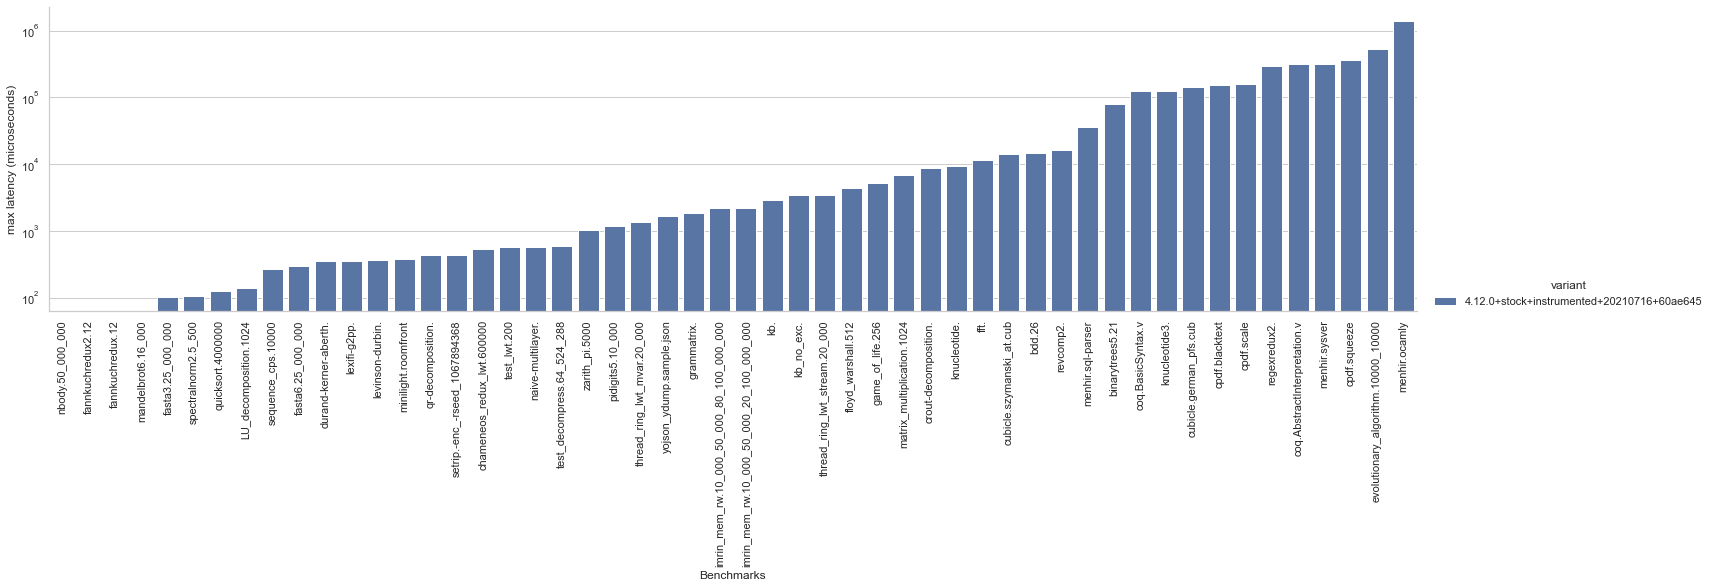

In [307]:
def plotLatencyAt(df,at,aspect):
    fdf = df.filter(["name","variant",at + "_latency"])
    fdf.sort_values(by=[at + '_latency'],inplace=True)
    fdf[at + "_latency"] = fdf[at + "_latency"] / 1000.0
    g = sns.catplot (x='name', y=at+'_latency', hue='variant', data = fdf, kind ='bar', aspect=aspect)
    g.set_xticklabels(rotation=90)
    g.ax.set_ylabel(at + " latency (microseconds)")
    g.ax.set_xlabel("Benchmarks")
    g.ax.set_yscale('log')
    return g

plotLatencyAt(df2,"max",4)

## 99.9th percentile latency

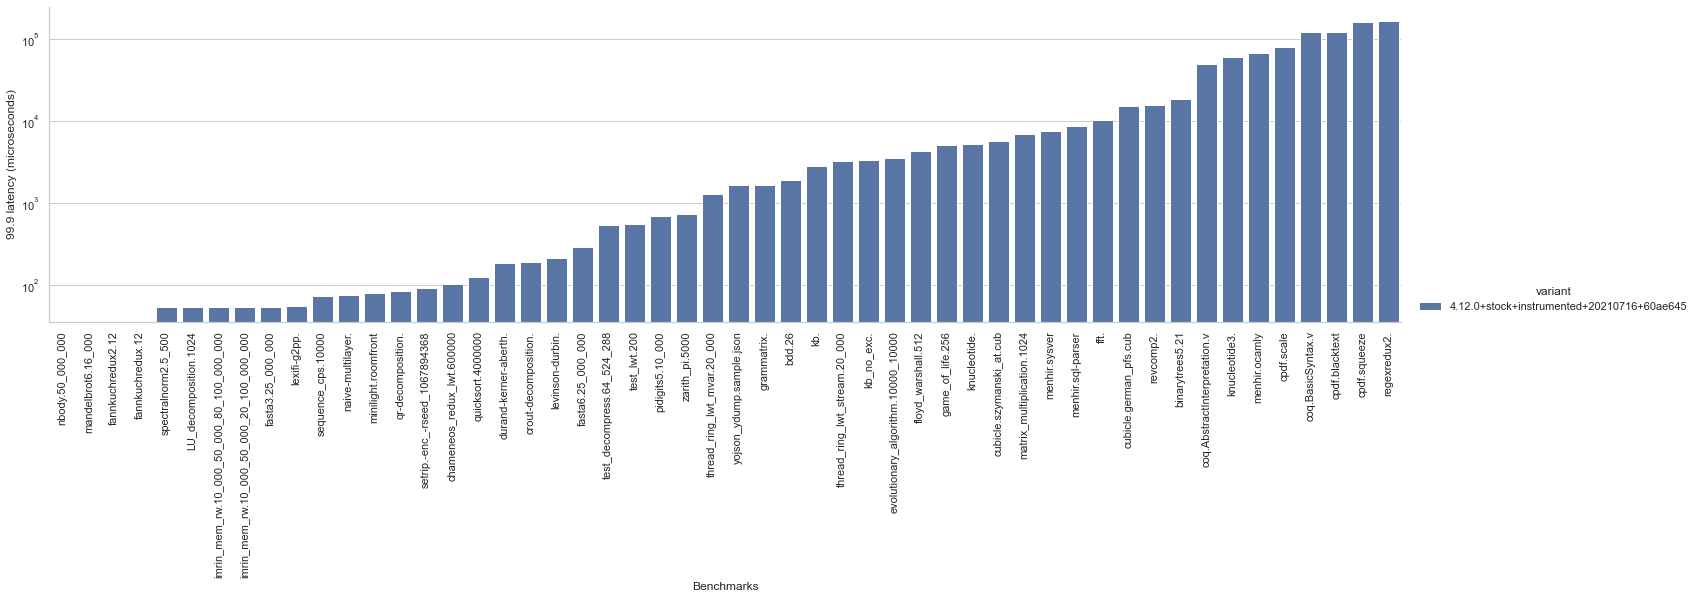

In [308]:
def getLatencyAt(df,percentile,idx):
    groups = df.groupby('variant')
    ndfs = []
    for group in groups:
        (v,df) = group
        count = 0
        for i, row in df.iterrows():
            df.at[i,percentile+"_latency"] = list(df.at[i,"distr_latency"])[idx]
        ndfs.append(df)
    return pd.concat(ndfs)

df2 = getLatencyAt(df2,"99.9",-1)
plotLatencyAt(df2,"99.9",4)

## 99th percentile latency

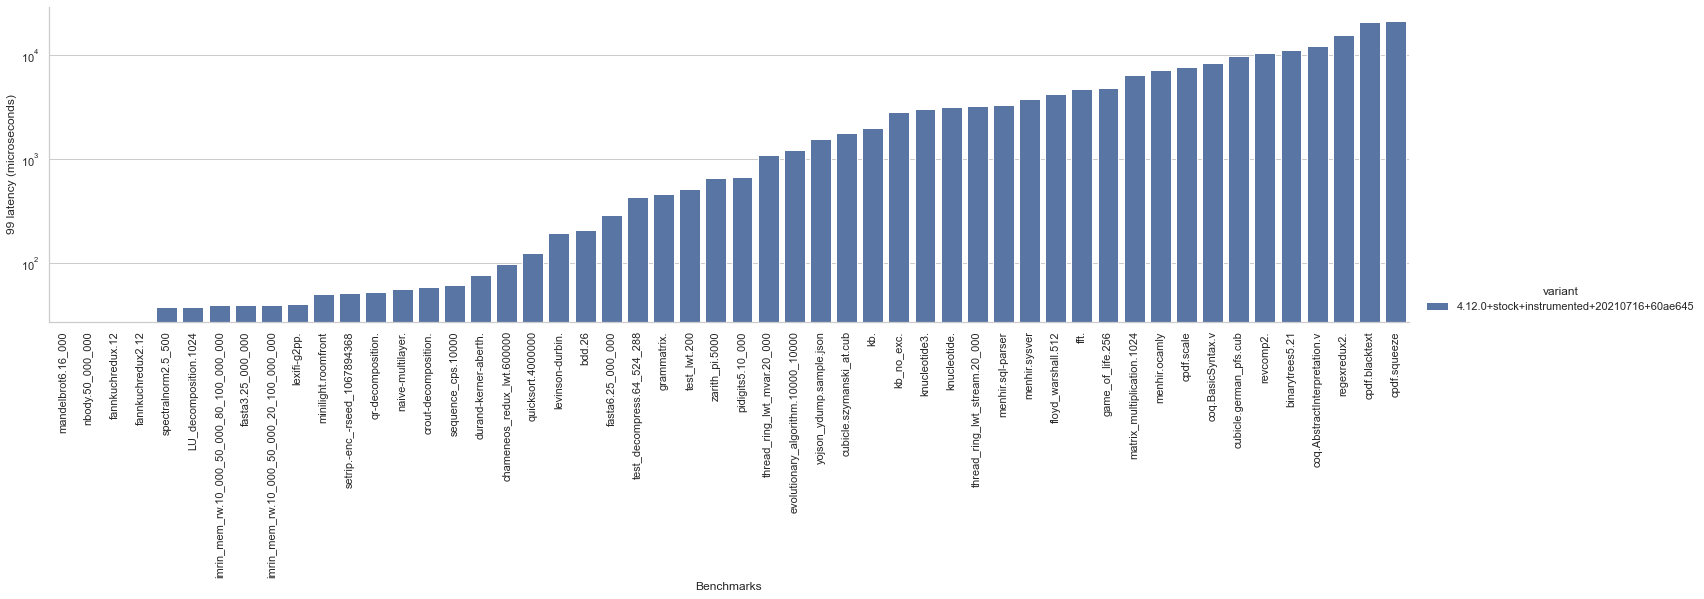

In [309]:
df2 = getLatencyAt(df2,"99",-2)
plotLatencyAt(df2,"99",4)